# 使用嵌入进行异常检测

## 概述
本教程演示如何使用 Gemini API 中的嵌入来检测数据集中的潜在异常值。您将使用[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)可视化 20 个新闻组数据集的子集，并检测每个分类聚类中心点特定半径之外的异常值。

有关开始使用 Gemini API 生成的嵌入的更多信息，请查看[Python 快速入门](python_quickstart:use_embeddings)。
## 前提条件
您可以在 Google Colab 中运行此快速入门。 

要在您自己的开发环境中完成本快速入门，请确保您的环境满足以下要求： 
- Python 3.9+ 
- 安装 jupyter 以运行笔记本

## 安装
首先，下载并安装 Gemini API Python 库。

In [1]:
# !pip install -q google.generativeai

In [2]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store your API key
# from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE


/home/st/miniconda3/envs/gemini/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 获取 API 密钥
在使用 Gemini API 之前，您必须先获取 API 密钥。如果您还没有密钥，请在 Google AI Studio 中一键创建密钥。

在 Colab 中，将密钥添加到左侧面板“🔑”下的秘密管理器中。将其命名为 API_KEY。 获得 API 密钥后，将其传递给 SDK。您可以通过两种方式执行此操作：
- 将密钥放入 GOOGLE_API_KEY 环境变量中（SDK 将自动从那里获取它）。
- 将密钥传递给 genai.configure(api_key=...)

In [3]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
# API_KEY=userdata.get('API_KEY')
GOOGLE_API_KEY = "YOUR-API-KEY"
genai.configure(api_key=GOOGLE_API_KEY)


```{tip}
要点：接下来，您将选择一个模型。任何嵌入模型都适用于本教程，但对于实际应用程序，选择特定模型并坚持使用非常重要。不同型号的输出互不兼容。
```
```{warning}
注意：目前，Gemini API [仅在某些区域可用](available_regions.md)。
```

In [4]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)


models/embedding-001


# 数据集
[20 个新闻组文本数据集](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)包含 20 个主题的 18,000 个新闻组帖子，分为训练集和测试集。训练和测试数据集之间的划分基于特定日期之前和之后发布的消息。在本教程中，您将使用训练子集。

In [5]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

这是训练集中的第一个示例。

In [6]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]


In [8]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train


,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


接下来，通过在训练数据集中获取 150 个数据点并选择一些类别来对一些数据进行采样。本教程使用科学类别。

In [9]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train


,index,Text,Label,Class Name
0,1650,List of large integer arithmetic packages\nOr...,11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,Re: Identifying / Securing Files\nOrganizatio...,11,sci.crypt
3,1653,Re: Off the shelf cheap DES keyseach machine ...,11,sci.crypt
4,1654,Re: disk safety measure?\nOrganization: Massa...,11,sci.crypt
...,...,...,...,...
595,2245,Re: What if the USSR had reached the Moon fir...,14,sci.space
596,2246,Re: space news from Feb 15 AW&ST\nNntp-Postin...,14,sci.space
597,2247,Re: Sunrise/ sunset times\nOrganization: Univ...,14,sci.space
598,2248,Re: First Spacewalk\nOrganization: Motorola\n...,14,sci.space


In [10]:
df_train['Class Name'].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

## 创建嵌入
在本节中，您将了解如何使用 Gemini API 中的嵌入为数据框中的不同文本生成嵌入。
### 使用模型 embedding-001 对嵌入进行 API 更改
对于新的嵌入模型 embedding-001，有一个新的任务类型参数和可选标题（仅在 task_type=RETRIEVAL_DOCUMENT 时有效）。  
这些新参数仅适用于最新的嵌入模型。任务类型为：  
| 任务类型 | 描述 |
|--- | --- |
| RETRIEVAL_QUERY | 指定给定文本是搜索/检索设置中的查询。|
| RETRIEVAL_DOCUMENT | 指定给定文本是搜索/检索设置中的文档。|
| SEMANTIC_SIMILARITY | 指定给定文本将用于语义文本相似性 (STS)。|
| CLASSIFICATION | 指定嵌入将用于分类。|
| CLUSTERING | 指定嵌入将用于聚类。|


In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)


100%|██████████| 600/600 [03:44<00:00,  2.68it/s]


## 降维
文档嵌入向量的长度为 768。为了可视化嵌入文档如何分组在一起，您将需要应用降维，因为您只能可视化 2D 或 3D 空间中的嵌入。上下文相似的文档在空间上应该更接近，而不是不相似的文档。

In [12]:
len(df_train['Embeddings'][0])

768

In [13]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

您将应用 t 分布式随机邻域嵌入 (t-SNE) 方法来执行降维。该技术减少了维数，同时保留了簇（靠近的点保持靠近）。对于原始数据，模型尝试构建一个分布，其中其他数据点是“邻居”（例如，它们具有相似的含义）。然后，它优化目标函数以在可视化中保持类似的分布。

In [14]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [15]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne


,TSNE1,TSNE2,Class Name
0,30.495018,5.358889,sci.crypt
1,43.887630,-8.861169,sci.crypt
2,30.483883,-5.904439,sci.crypt
3,41.567837,2.472937,sci.crypt
4,32.781998,-1.607547,sci.crypt
...,...,...,...
595,-12.525240,25.403387,sci.space
596,-15.025298,10.273179,sci.space
597,7.069860,13.220440,sci.space
598,-11.374259,18.656891,sci.space


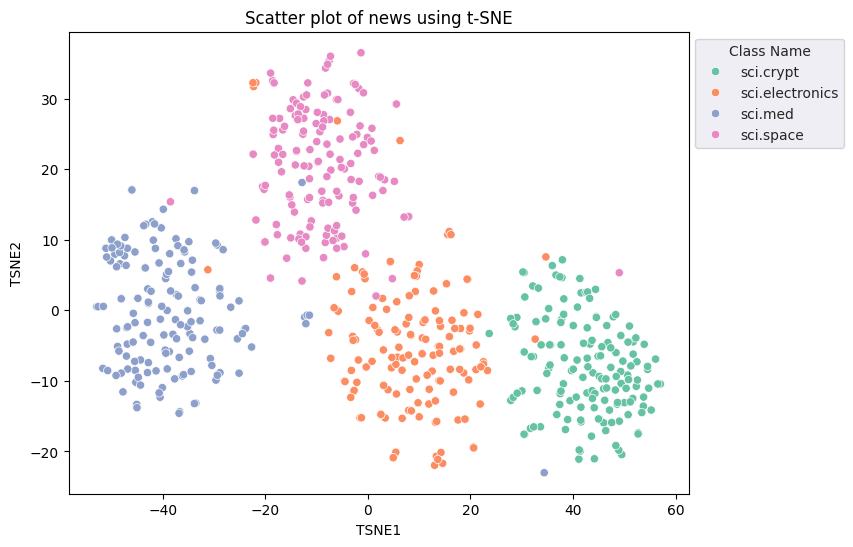

In [16]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');


## 异常值检测
要确定哪些点异常，您将确定哪些点是异常值和异常值。首先找到质心或代表簇中心的位置，然后使用距离来确定异常点。

首先获取每个类别的质心。

In [17]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids


,TSNE1,TSNE2
Class Name,,
sci.crypt,42.562511,-8.157657
sci.electronics,8.264927,-4.836580
sci.med,-38.439342,-0.223306
sci.space,-8.939692,20.018568


In [18]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids


In [22]:
emb_c = get_embedding_centroids(df_train)

对照其余点绘制您找到的每个质心。

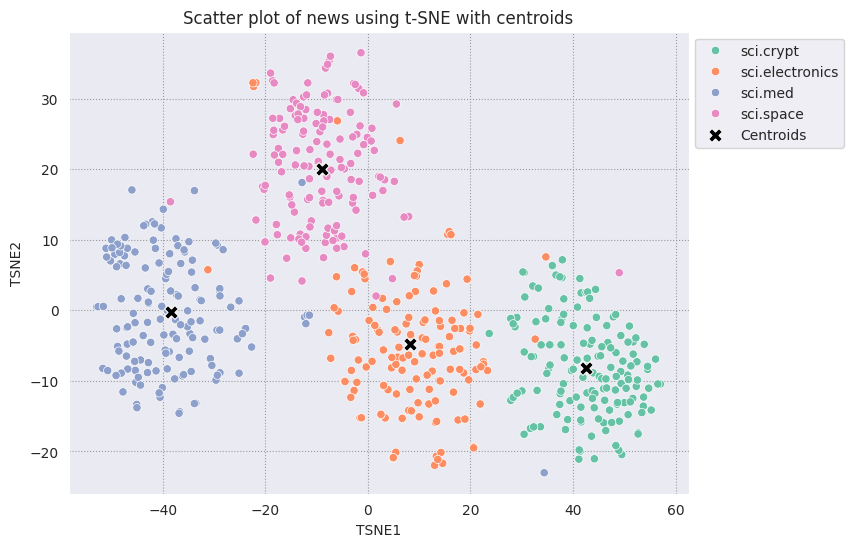

In [23]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');


选择一个半径。任何超出该类别质心界限的值都被视为异常值。

In [24]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])


In [25]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))


/tmp/ipykernel_372222/4116937739.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Outlier'] = dist > radius


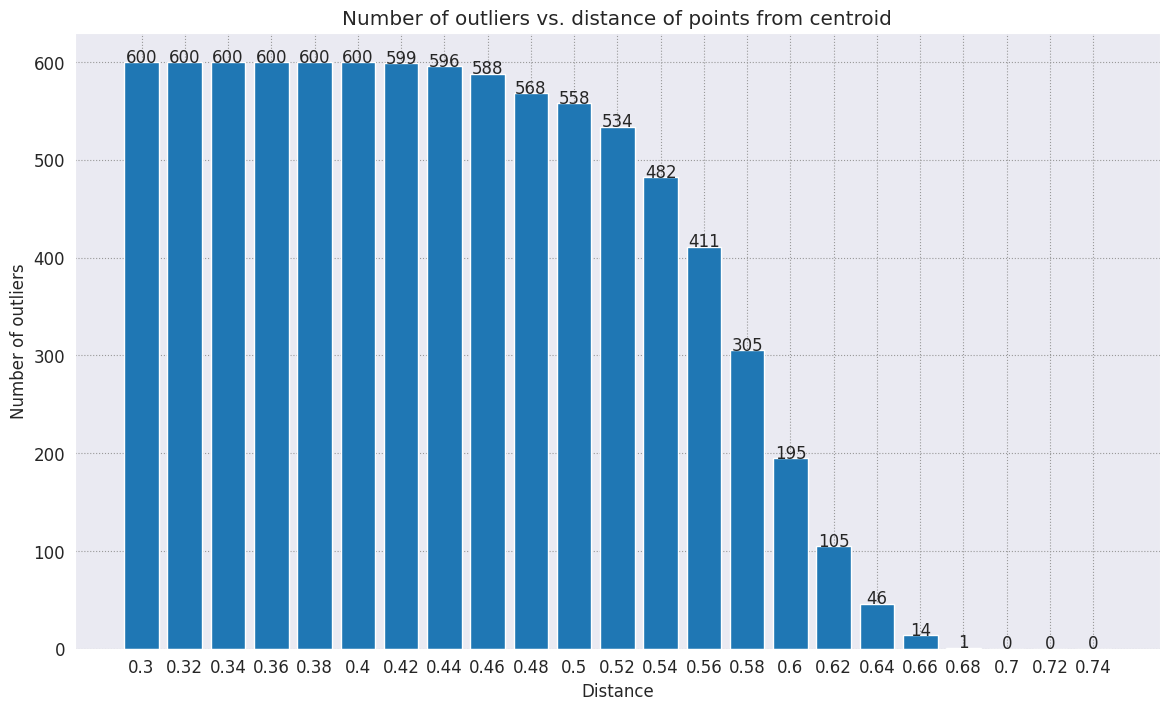

In [26]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()


根据您希望异常检测器的灵敏度，您可以选择要使用的半径。目前使用的是 0.62，但您可以更改该值。

In [27]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()


,Text,Label,Class Name,Embeddings,Outlier
0,List of large integer arithmetic packages\nOr...,11,sci.crypt,"[0.015404858, -0.021492945, -0.09030825, -0.02...",True
20,Pseudo-Random Character Generators \nOrganiza...,11,sci.crypt,"[0.003974339, -0.07057476, -0.07918037, -0.025...",True
35,LGA ncrypt source\nOrganization: Massachusett...,11,sci.crypt,"[0.02029423, -0.011940984, -0.0636546, -0.0247...",True
58,* REPORT ON PRIVACY-PROTECTING OFF-LINE CASH ...,11,sci.crypt,"[0.0060990495, 0.01995056, -0.08278795, -0.050...",True
62,Marc VanHeyningen <>RIPEM Frequently Asked Que...,11,sci.crypt,"[0.016936606, -0.03775989, -0.031252615, -0.02...",True


In [28]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

绘制异常值并使用透明红色表示它们。

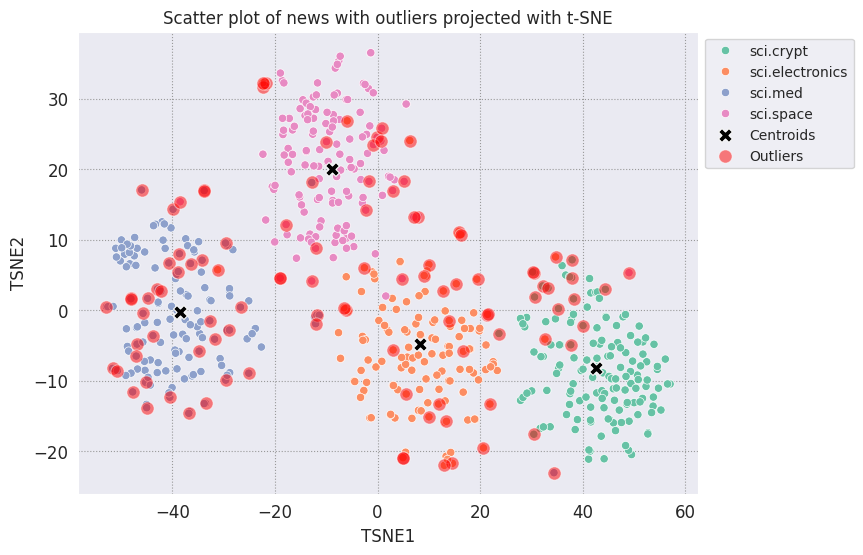

In [29]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');


使用数据名的索引值打印一些异常值在每个类别中的示例。此处，打印出每个类别的第一个数据点。探索每个类别中的其他点以查看被视为异常值或异常的数据。

In [30]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])


 List of large integer arithmetic packages
Organization: Michigan State University
Lines: 285
NNTP-Posting-Host: scss3.cl.msu.edu
Summary: C functions to do arbitrary-precision arith
X-Newsreader: TIN [version 1.1 PL8]

This is the file BIGNUMS.TXT from ripem.msu.edu, last updated April 1993.

In response to Email requests, I have assembled this list of
large-integer arithmetic packages of which I have heard.
Most of these are C function libraries, available in source form.

For your convenience, I have placed copies of
some of these on ripem.msu.edu .  They are
available for anonymous FTP in the directory "pub/bignum".
However, what I have may not be the most current version in all cases.

Here they are, in no particular order:

mp
    Multiple Precision package that comes with some Unixes
    
    Multiple precision package accessed via -lmp flag on your
    compiler.  Provides +, -, *, /, gcd, exponentiation,
    sqrt.  Comes with SunOS, NeXT Mach, BBN Mach 1000, 
    and probably a

In [31]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])


 Motorola XC68882RC33 and RC50
Organization: University of Houston
Lines: 17
Distribution: world
NNTP-Posting-Host: rosie.uh.edu
Keywords: Motorola, FPU, 68882, 68030, 33/50 MHz, problems 
News-Software: VAX/VMS VNEWS 1.41    

I just installed a Motorola XC68882RC50 FPU in an Amiga A2630 board .  Previously
a MC68882RC25 was installed and everything was working perfectly.  Now the
systems displays a yellow screen  when it check for
the presence/type of FPU.  When I reinstall an MC68882RC25 the system works
fine, but with the XC68882 even at 25 MHz it does not work.  The designer
of the board mentioned that putting a pullup resistor on data_strobe 
might help, but that didn't change anything.  Does anybody have some
suggestions what I could do?  Does this look like a CPU-FPU communications
problem or is the particular chip dead ?
Moreover, the place I bought it from is sending me an XC68882RC33.  I thought
that the 68882RC33 were labeled MC not XC . 
Are there any MC68882RC33?

Thanks


In [32]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 Re: New planet/Kuiper object found?
Organization: University of Western Ontario, London
Distribution: sci
Nntp-Posting-Host: prism.engrg.uwo.ca
Lines: 5

	If the  new  Kuiper belt object *is*  called 'Karla', the next
one  should be called 'Smiley'.

							James Nicoll




## 下一步
您现在已经使用嵌入创建了一个异常检测器！尝试使用您自己的文本数据将它们可视化为嵌入，并选择一些边界以便您可以检测异常值。您可以执行降维以完成可视化步骤。请注意，t-SNE 擅长对输入进行聚类，但可能需要较长时间才能收敛，或者可能会陷入局部最小值。如果您遇到此问题，您可以考虑的另一种技术是[主成分分析 (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)。

要了解如何使用 Gemini API 中的其他服务，请访问[Python 快速入门](python_quickstart.ipynb)。

要了解有关如何使用嵌入的更多信息，请查看可用的[示例](https://ai.google.dev/examples?keywords=embed)。要了解如何从头开始创建它们，请参阅 TensorFlow 的[词嵌入](https://www.tensorflow.org/text/guide/word_embeddings)教程。